In [1]:
import pandas as pd
import os
import numpy as np
import pandas as pd

### Задание 1 ###

Опишите задачу с точки зрения NLP. Что это за задача, какие классические методы существуют для ее решения? Как ее можно решать через LLM? Как обычно оценивают качество моделей в этой задаче?

Это Named-entity recognition (NER) - задача классификации токенов по классам сущностей. Ее можно решать классическим способом при помощи правил (задаем правила, которые определяют, какие последовательности могут быть сущностями). Или при помощи машинного обучения, где модели, например, BERT, которые, конечно, файнтюнят специально под эту задачу, обучаются данных, в которых сущности уже пвыделены в тексте. 
LLM хорошо справляются с этой задачей, если дать им задать правильный промпт (https://arxiv.org/pdf/2304.10428). Тогда задача разделяется на два этапа: получить эмбеддинги сущностей и классифицировать их. 
Для оценки качества NER обычно используют F1 меру с микро-усреднением. Конкретно в этом задании могут использоваться и другие метрики, но чаще всего (при другой разметке данных - BIO) особенность подсчета F1 для NER заключается в том, что в некоторых ситуациях неправильные ответы могут засчитываться как правильные. Например, если модель предсказала ['I-PER', 'I-PER'], то мы можем догадаться, что на самом деле должно быть ['B-PER', 'I-PER'], так как сущность не может начинаться с I-. f1_score учитывает это и поэтому работает только с текстовыми представлениями меток.

### Задание 2 ###

Реализуйте чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer". Выведите шапку датафрейма.

In [2]:
data_path = ''
data = []

def get_document_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        text_start_index = 4
        document_text = ''.join(lines[text_start_index:]).strip()
    return document_text

for file_name in os.listdir(os.path.join(data_path, 'raw', 'ru')):
    if file_name.endswith('.txt'):
        document_id = file_name.replace('.txt', '')
        document_text = get_document_text(os.path.join(data_path, 'raw', 'ru', file_name))
        
        out_file_name = file_name.replace('.txt', '.out')
        with open(os.path.join(data_path, 'annotated', 'ru', out_file_name), 'r', encoding='utf-8') as file:
            lines = file.readlines()
            for line in lines:
                parts = line.strip().split('\t')
                if len(parts) == 4:
                    entity, entity_full, entity_type, gold_answer = parts
                    gold_answer_type = gold_answer.split('-')[0]
                    data.append([document_id, document_text, entity, gold_answer_type])

df = pd.DataFrame(data, columns=["document_id", "document_text", "entity", "gold_answer"])

df = df[df['gold_answer'].isin(["PER", "ORG", "LOC", "EVT", "PRO"])]
df = df.reset_index(drop=True)
print(df.head())

         document_id                                      document_text  \
0  brexit_ru_file_10  Тереза Мэй рассчитывает усидеть в седле до зав...   
1  brexit_ru_file_10  Тереза Мэй рассчитывает усидеть в седле до зав...   
2  brexit_ru_file_10  Тереза Мэй рассчитывает усидеть в седле до зав...   
3  brexit_ru_file_10  Тереза Мэй рассчитывает усидеть в седле до зав...   
4  brexit_ru_file_10  Тереза Мэй рассчитывает усидеть в седле до зав...   

          entity gold_answer  
0         Brexit         EVT  
1  Борис Джонсон         PER  
2        Джонсон         PER  
3       Джонсона         PER  
4             ЕС         ORG  


### Задание 3 ###

Напишите функцию, которая принимает на вход строку датафрейма и выдает текст входного сообщения для LLM.

In [3]:
def generate_llm_prompt(row):
    document_text = row['document_text']
    
    prompt = f"""
    Ты помощник, который пишет по шаблону. Пожалуйста, реши задачу NER: найди все сущности в тексте ниже и классифицируй их по следующим типам: {', '.join(["PER", "ORG", "LOC", "EVT", "PRO"])}.

    Пример 1:
    Текст: "Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit."
    Сущности: 
    - Тереза Мэй: PER
    - Brexit: EVT

    Пример 2:
    Ранее Мэй пообещала отправить в отставку Джонсона."
    Сущности: 
    - Мэй: PER
    - Джонсона: PER

    Старайся находить короткие конкретные сущности (например, не "министром по вопросам брекзита Дэвид Дэвис", а "Дэвид Дэвис").
    Пожалуйста, реши задачу для следующего текста:
    {document_text}
    """
    
    return prompt

row = df.iloc[0]
print(generate_llm_prompt(row))


    Ты помощник, который пишет по шаблону. Пожалуйста, реши задачу NER: найди все сущности в тексте ниже и классифицируй их по следующим типам: PER, ORG, LOC, EVT, PRO.

    Пример 1:
    Текст: "Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit."
    Сущности: 
    - Тереза Мэй: PER
    - Brexit: EVT

    Пример 2:
    Ранее Мэй пообещала отправить в отставку Джонсона."
    Сущности: 
    - Мэй: PER
    - Джонсона: PER

    Старайся находить короткие конкретные сущности (например, не "министром по вопросам брекзита Дэвид Дэвис", а "Дэвид Дэвис").
    Пожалуйста, реши задачу для следующего текста:
    Тереза Мэй рассчитывает усидеть в седле до завершения процедуры Brexit

Тем не менее, по сведениям британских СМИ, на предстоящей в конце сентября конференции партии тори противники Мэй навяжут ей серьезный бой, из которого не факт, что она выйдет победителем. Фаворит букмекеров в качестве возможного сменщика нынешнего премьера, бывший министр иностранных дел Британи

### Задание 4 ###

Получите ответы GigaChat для всех документов. Документов всего 9, поэтому сделать это можно вручную, пользуясь веб-интерфейсом GigaChat или ботом в ВК или Телеграме. Не очищайте историю сообщений, чтобы потом продемонстрировать подлинность ответов на онлайн-собеседовании.
Внесите ответы GigaChat в датафрейм, сохраните его.

In [4]:
import numpy as np
df['predicted_answer'] = np.nan

In [35]:
text = """
Министр иностранных дел Великобритании: PRO
Борис Джонсон: PER
агентство Рейтер: ORG
премьер Тереза Мэй: PER
Даунинг-Стрит: LOC
министр по вопросам брекзита: PRO
Дэвид Дэвис: PER
Великобритания: LOC
Евросоюз: ORG
Brexit: EVT
"""

lines = text.split('\n')
result_dict = {}

for line in lines:
    if line:
        key, value = line.split(': ')
        result_dict[key] = value

df.loc[(df['document_id'] == 'brexit_ru_file_1003') & (df['predicted_answer'].isna()), 'predicted_answer'] = df['entity'].map(result_dict)

print(df.head())

         document_id                                      document_text  \
0  brexit_ru_file_10  Тереза Мэй рассчитывает усидеть в седле до зав...   
1  brexit_ru_file_10  Тереза Мэй рассчитывает усидеть в седле до зав...   
2  brexit_ru_file_10  Тереза Мэй рассчитывает усидеть в седле до зав...   
3  brexit_ru_file_10  Тереза Мэй рассчитывает усидеть в седле до зав...   
4  brexit_ru_file_10  Тереза Мэй рассчитывает усидеть в седле до зав...   

          entity gold_answer predicted_answer  score  doc_length  
0         Brexit         EVT              EVT    1.0        5160  
1  Борис Джонсон         PER              PER    1.0        5160  
2        Джонсон         PER              NaN    0.0        5160  
3       Джонсона         PER              NaN    0.0        5160  
4             ЕС         ORG              NaN    0.0        5160  


### Задание 5 ###

Реализуйте самостоятельно алгоритм для подсчета метрик score_fn(gold: str, pred: str) → float. Можно пользоваться только библиотеками numpy, scipy, pandas. Напишите юнит-тесты. Возможно ли ускорить вычисление функции через векторную реализацию? Поясните решение и обоснуйте, почему выбрали именно такую метрику.

In [17]:
def score_fn(gold: pd.Series, pred: pd.Series) -> float:
    pred = pred.fillna('O')
    tp = (gold == pred) & (gold != 'O')
    tp_count = tp.sum()
    fp = (gold != pred) & (pred != 'O') & (pred != 'NaN')
    fp_count = fp.sum()
    fn = (gold != pred) & (gold != 'O') & (gold != 'NaN')
    fn_count = fn.sum()
    precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0.0
    recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1

In [24]:
import unittest

class TestScoreFn(unittest.TestCase):
    def test_perfect_match(self):
        gold = pd.Series(['PER', 'LOC', 'ORG'])
        pred = pd.Series(['PER', 'LOC', 'ORG'])
        self.assertAlmostEqual(score_fn(gold, pred), 1.0)

    def test_no_predictions(self):
        gold = pd.Series(['PER', 'LOC', 'ORG'])
        pred = pd.Series([np.nan, np.nan, np.nan])
        self.assertAlmostEqual(score_fn(gold, pred), 0.0)

    def test_no_gold_entities(self):
        gold = pd.Series(['O', 'O', 'O'])
        pred = pd.Series(['PER', 'LOC', 'ORG'])
        self.assertAlmostEqual(score_fn(gold, pred), 0.0)

    def test_partial_correct(self):
        gold = pd.Series(['PER', 'LOC', 'ORG', 'O'])
        pred = pd.Series(['PER', 'ORG', 'O', 'O'])
        precision = 1 / (1 + 1)
        recall = 1 / (1 + 1)
        expected_f1 = 2 * precision * recall / (precision + recall)
        self.assertAlmostEqual(score_fn(gold, pred), expected_f1)

    def test_mixed_predictions(self):
        gold = pd.Series(['PER', 'LOC', 'ORG', 'O', 'PER'])
        pred = pd.Series(['PER', np.nan, 'ORG', 'LOC', 'O'])
        precision = 2 / (2 + 1)
        recall = 2 / (2 + 1)
        expected_f1 = 2 * precision * recall / (precision + recall)
        self.assertAlmostEqual(score_fn(gold, pred), expected_f1)

### Задание 6 ###

Вычислите метрики для каждой строки в датафрейме. Сагрегируйте результаты а) по каждой сущности, б) по каждому документу. Изобразите результаты на графиках. Какие выводы можно сделать?

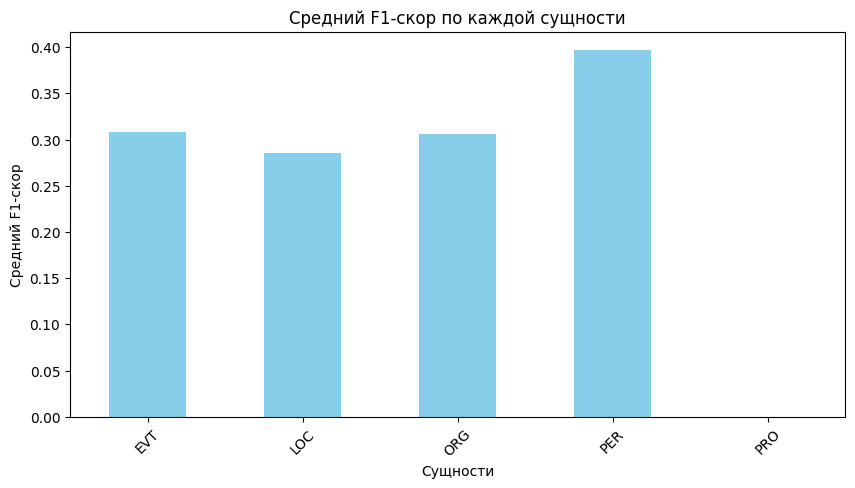

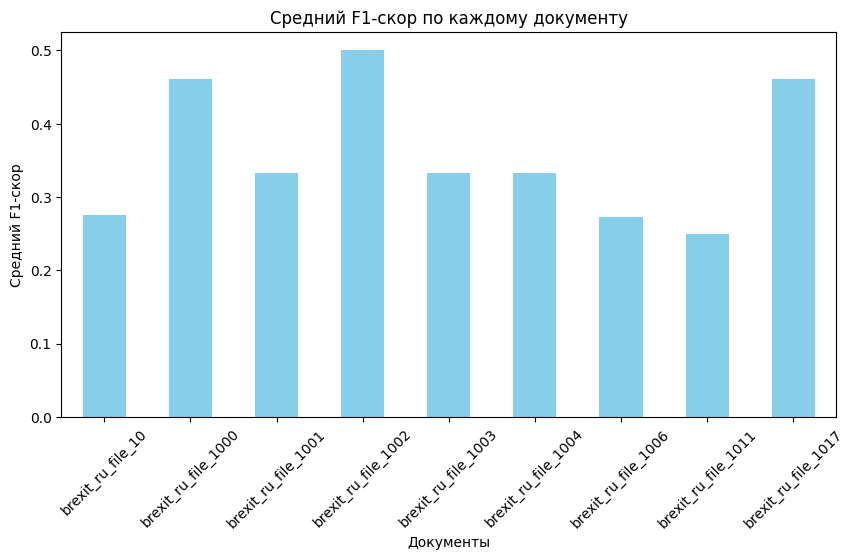

In [32]:
import matplotlib.pyplot as plt

def score_fn(gold: str, pred: str) -> float:
    if pd.isna(pred):
        pred = 'O'
    
    if gold == pred and gold != 'O':
        return 1.0
    else:
        return 0.0

df['score'] = df.apply(lambda row: score_fn(row['gold_answer'], row['predicted_answer']), axis=1)

entity_scores = df.groupby('entity')['score'].mean()

document_scores = df.groupby('document_id')['score'].mean()

entity_scores, document_scores
df['score'] = df.apply(lambda row: score_fn(row['gold_answer'], row['predicted_answer']), axis=1)

entity_scores = df.groupby('gold_answer')['score'].mean()

document_scores = df.groupby('document_id')['score'].mean()

plt.figure(figsize=(10, 5))
entity_scores.plot(kind='bar', color='skyblue')
plt.title('Средний F1-скор по каждой сущности')
plt.xlabel('Сущности')
plt.ylabel('Средний F1-скор')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
document_scores.plot(kind='bar', color='skyblue')
plt.title('Средний F1-скор по каждому документу')
plt.xlabel('Документы')
plt.ylabel('Средний F1-скор')
plt.xticks(rotation=45)
plt.show()

### Задание 7 ###

Есть ли зависимость метрик от длины документа? Постройте графики, чтобы ответить на вопрос.

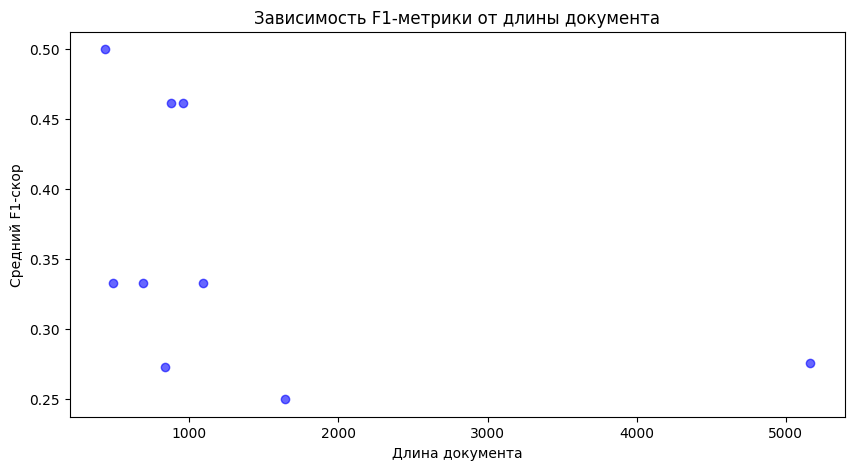

In [33]:
df['doc_length'] = df['document_text'].apply(len)
document_scores_with_length = df.groupby('document_id').agg({'score': 'mean', 'doc_length': 'first'})
plt.figure(figsize=(10, 5))
plt.scatter(document_scores_with_length['doc_length'], document_scores_with_length['score'], color='blue', alpha=0.6)
plt.title('Зависимость F1-метрики от длины документа')
plt.xlabel('Длина документа')
plt.ylabel('Средний F1-скор')
plt.show()

In [34]:
df.to_csv('sberdevices.csv', index=False)  

### Задание 8 ###

Проведите анализ ошибок. Когда модель чаще отвечает правильно, а когда ошибается? Предложите варианты, как повысить метрики.

Модель хорошо справляется с распознаванием персон и организаций. При этом метрика значительно ниже для сущностей LOC и PRO, это может быть связано либо с недостаточным количеством обучающих примеров для этих классов или либо со сложностью их контекста.
В длинных документах, как видно из третьего графика, F1-метрика снижается
Как повысить метрики?
1. Нужно, чтобы модель видела приблизительно равное количество примеров всех типов сущностей (соблюдался баланс классов). А именно, добавить больше примеров с сущностями, которые имеют низкий f1 скор(`LOC`, `PRO`). Для этого также можно использовать аугментации.
2. Важно, что в гигачат нельзя было отправить слишком длинные новости (как в десятом документе), так что его нужно было отправлять по частям. Тем не менее, из-за того, что на более длинных документах модель выдает ответ хуже, стоит внедрить более сильные модели, которые могут работать с большими последовательностями (longformer, например).



### Задание 9 ###

Сделайте выводы по всему исследованию. Напишите, чему научились и что нового попробовали.

Мне было интересно в целом поработать с гигачатом, поскольку это мой первый опыт с ним. Я увидела, как существующие модели, доступные обычному пользователю, справляются с задачей NER.